In [1]:
# pip install watermark
%load_ext watermark

In [2]:
%watermark -v -m -p numpy,scipy,pandas,matplotlib,sklearn -g 
#,statsmodels

CPython 3.5.2
IPython 6.4.0

numpy 1.14.5
scipy 1.1.0
pandas 0.23.1
matplotlib 2.2.2
sklearn 0.19.1

compiler   : GCC 5.4.0 20160609
system     : Linux
release    : 4.9.89-boot2docker
machine    : x86_64
processor  : x86_64
CPU cores  : 2
interpreter: 64bit
Git hash   :


In [3]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
from glob import glob
import os
import pickle
#pip install tqdm
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
import json
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker
%matplotlib inline
import datetime
from datetime import datetime, date, time,timedelta
# настройка внешнего вида графиков в seaborn
sns.set_context(
    "notebook", 
    font_scale = 1.5,       
    rc = { 
        "figure.figsize" : (12, 9), 
        "axes.titlesize" : 18 
    }
)

import requests
from datetime import datetime, date, time
from datetime import timedelta

import collections

In [4]:
PATH_TO_DATA = '/notebooks/misha/data/'
FILE_NAME_DATA1 = 'data_n3.1_h_all.csv'
columns_input_init = ['house_id2', 'trans_id', 'empty', 'doc_id', 'name_text',
       'sell_small', 'date', 'sell_big', 'piece_text','house_id','house_name']

In [3]:
#!head -n 50 {os.path.join(PATH_TO_DATA,'11.csv')}
#!head -n 50 {os.path.join(PATH_TO_DATA,FILE_NAME_DATA1)}

In [13]:
#!grep -n ";;;;;;;;;;" {os.path.join(PATH_TO_DATA,FILE_NAME_DATA1)}

In [26]:
#Data preparation
#document 
document_line_len = 500000
document_line_offset = 2


#cut and convert csv file
!head -n{document_line_len}  {os.path.join(PATH_TO_DATA,FILE_NAME_DATA1)} | tail -n+{document_line_offset}  > {os.path.join(PATH_TO_DATA,'buffer.txt')}
data_a1 = pd.read_csv(os.path.join(PATH_TO_DATA,'buffer.txt'), encoding="cp1251",sep=';')
#assign columns
data_a1.columns = columns_input_init
#delete unused columns
data_a1 =  data_a1.drop(['empty','piece_text'],axis = 1)
#clear empty cells
data_a1 = data_a1[data_a1['house_id2'].isna()==False]

#some manipulations
data_a1['item_id'] = np.nan
#helper filter flag
data_a1['filter'] = 0
#manipulations
data_a1.loc[data_a1['name_text'].isna()==False,'item_id'] = data_a1.loc[data_a1['name_text'].isna()==False,'house_id2']
data_a1.loc[data_a1['name_text'].isna()==False,'filter'] = 1
#filling na
data_a1 = data_a1.fillna(method='ffill')
#remove trash
data_a1 = data_a1[data_a1['filter']!=1]
#replace some " " and "/""
data_a1['item_id'] = data_a1['item_id'].replace(to_replace='/', value='', regex=True)
data_a1[['house_id2','trans_id','doc_id','sell_small','sell_big','house_id','item_id']] = \
    data_a1[['house_id2','trans_id','doc_id','sell_small','sell_big' \
             ,'house_id','item_id']].replace(to_replace=' ', value='', regex=True)
#convert to signed data type
#help function to datatype convert
def to_unsigned(x):
    return pd.to_numeric(x,downcast='signed')
data_a1[['house_id2','trans_id','doc_id','sell_small','sell_big','house_id','item_id']] = \
        data_a1[['house_id2','trans_id','doc_id','sell_small','sell_big','house_id','item_id']].apply(to_unsigned)
#string to datetime convertion
def lookup(s): #VERY FAST
    dates = {date:pd.to_datetime(date,format='%d.%m.%Y') for date in s.unique()}
    return s.map(dates)
def get_week(x):
    delta_t = x-start_date
    return delta_t.days//7
def get_day_long(x):
    delta_t = x-start_date
    return delta_t.days
data_a1['date'] = lookup(data_a1['date'])
#creating date
#start_date = pd.to_datetime("01.01.2011",format='%d.%m.%Y')
start_date = datetime.strptime("2011-1-1", "%Y-%W-%w")
end_date = datetime.strptime("2018-30-1", "%Y-%W-%w")

###Add ne columns
data_a1['date_dayweek'] = pd.DatetimeIndex(data_a1['date']).dayofweek
data_a1['date_month'] = pd.DatetimeIndex(data_a1['date']).month
data_a1['date_daymonth'] = pd.DatetimeIndex(data_a1['date']).day
#data_a1['date_day_long'] = (pd.DatetimeIndex(data_a1['date'])-start_date).days
data_a1['date_year'] = pd.DatetimeIndex(data_a1['date']).year
data_a1['date_month_long'] = (data_a1['date_year']-start_date.year)*12+data_a1['date_month']
data_a1['date_week_long'] = data_a1['date'].apply(get_week)
data_a1['date_day_long'] = data_a1['date'].apply(get_day_long)
data_a1['date_week_year'] = pd.DatetimeIndex(data_a1['date']).week
#sell out / sell in
data_a1['sell_out'],data_a1['sell_in'] = 0,0
data_a1.loc[data_a1['sell_big']>0,'sell_in']=data_a1.loc[data_a1['sell_big']>0,'sell_big']
data_a1.loc[data_a1['sell_big']<0,'sell_out']=data_a1.loc[data_a1['sell_big']<0,'sell_big']*-1
#drop unused
data_a1 =  data_a1.drop(['house_id2','filter','doc_id','sell_small'],axis = 1)

#filling house and items dictionary
house_vocab = {}
item_vocab = {}
for k in data_a1['house_id'].unique():
    if k not in house_vocab:
        house_vocab[k]=data_a1[data_a1['house_id']==k]['house_name'].iloc[0]
for k in data_a1['item_id'].unique():
    if k not in item_vocab:
        item_vocab[k]=data_a1[data_a1['item_id']==k]['name_text'].iloc[0]      
print("===========================\nHouse dictionary\n",house_vocab)
print("===========================\nItems dictionary\n",item_vocab)
#drop text fields
data_a1 =  data_a1.drop(['house_name','name_text'],axis = 1)

#add rest count 
data_a1['rest'] = 0
data_a1_help = data_a1.iloc[:0]
for n in house_vocab:
    for k in item_vocab:
        tmp_arr = data_a1[(data_a1['item_id']==k)&(data_a1['house_id']==n)]
        tmp_arr['rest'] = tmp_arr['sell_big'].iloc[::-1].cumsum()
        data_a1_help = pd.concat([data_a1_help,tmp_arr])
data_a1 = data_a1_help

#============================ read working calendar

with open('./data/calendar/content.json', encoding="utf-8") as f:
    calendar_json = json.load(f)

#building calendar
cld_inp = pd.DataFrame([],columns = ['year','month','days'])
for k in calendar_json:
    month_num = 1
    for j in ['Январь','Февраль','Март','Апрель','Май','Июнь','Июль','Август','Сентябрь','Октябрь','Ноябрь','Декабрь']:
        #cld_inp.loc[len(cld_inp)]=[int(k['Год/Месяц']),month_num,list(map(int, k[j].replace('*','').replace('+','').split(',')))] 
        #cld_inp.loc[len(cld_inp)]=[int(k['Год/Месяц']),month_num,list(map(int, k[j].replace('+','').split(',')))] 
        cld_inp.loc[len(cld_inp)]=[int(k['Год/Месяц']),month_num,list(map(int, [x for x in k[j].replace('+','').split(',') if '*' not in x]))] 
        #[x for x in k[j].replace('+','').split(',') if '*' in x]
        month_num+=1
        
#calculating working day per week
cld_out = collections.Counter() #pd.DataFrame([],columns = ['week','wd'])
start_date = datetime.strptime("2011-1-1", "%Y-%W-%w")
end_date = datetime.strptime("2018-30-1", "%Y-%W-%w")
delta_days = (end_date-start_date).days
shift_day = timedelta(1) ##shift = 1 day
day_week = 0
week_num = 0
act_date = start_date
for d in range(1,delta_days+1):
    day_week+=1
    if act_date.day not in list(cld_inp.loc[(cld_inp['year']==act_date.year)&(cld_inp['month']==act_date.month)]['days'])[0]:
        #print(act_date.day)
        cld_out[week_num] += 1      
    act_date = act_date + shift_day
    if day_week >= 7:
        week_num += 1
        day_week = 0
        
def get_work_day_per_week(x):
    return cld_out[x['date_week_long']]
data_a1['wdperw'] = 0    
data_a1['wdperw'] = data_a1.apply(get_work_day_per_week,axis = 1)

#output
data_a1.describe()


House dictionary
 {2720: 'Самара-ФТ', 2500: 'Москва-ФТ', 2501: 'Вэйпарк-ФТ', 2310: 'Сургут-ФТ', 2700: 'Уфа-ФТ', 2699: 'Казань-РС', 1100: 'Центр.склад-Фиера', 2640: 'Пенза СТАРЫЙ-ФТ', 2710: 'Оренбург-ФТ', 2200: 'Челябинск-ФТ', 2820: 'Саратов-ФТ', 2650: 'Йошкар-Ола-ФТ', 2400: 'Пермь-ФТ', 2320: 'Курган-ФТ', 2210: 'Магнитогорск-ФТ', 2630: 'Ульяновск СТАРЫЙ-ФТ', 2600: 'Казань-ФТ', 2300: 'Тюмень-ФТ', 2410: 'Киров-ФТ', 2800: 'Ульяновск-ФТ', 2610: 'Чебоксары-ФТ', 2100: 'Екатеринбург-ФТ', 2110: 'Нижний Тагил-ФТ', 2420: 'Ижевск-ФТ', 2810: 'Пенза-ФТ', 2620: 'Набережные Челны-ФТ', 2730: 'Тольятти-ФТ', 2430: 'Сыктывкар-ФТ'}
Items dictionary
 {9391402: 'AVS HK TIP-ON, Cиловой мех-м  20K2701T', 8433996: 'TBX, Напр. с BM, 30 кг, 350 мм, лев. NEW', 9350503: 'CLIP top BM, Петля п/фальш вкл 79B9550'}


,trans_id,sell_big,house_id,item_id,date_dayweek,date_month,date_daymonth,date_year,date_month_long,date_week_long,date_day_long,date_week_year,sell_out,sell_in,rest,wdperw
count,121070.000000,121070.000000,121070.000000,1.210700e+05,121070.000000,121070.000000,121070.000000,121070.000000,121070.000000,121070.000000,121070.000000,121070.000000,121070.000000,121070.000000,121070.000000,121070.000000
mean,579.288982,0.049228,2388.068258,9.327993e+06,2.023639,6.632502,16.169530,2015.692921,62.947559,270.869043,1898.106938,27.099025,9.885876,9.935104,324.224837,4.853275
std,108.445302,135.032373,328.175472,1.510502e+05,1.425732,3.403422,8.549916,1.643598,19.310621,83.940155,587.610273,14.814320,45.278959,126.440190,836.312185,0.578788
min,101.000000,-3000.000000,1100.000000,8.433996e+06,0.000000,1.000000,1.000000,2012.000000,24.000000,104.000000,728.000000,1.000000,0.000000,0.000000,-794.000000,0.000000
25%,601.000000,-4.000000,2210.000000,9.350503e+06,1.000000,4.000000,9.000000,2014.000000,46.000000,199.000000,1395.000000,14.000000,2.000000,0.000000,92.000000,5.000000
50%,601.000000,-2.000000,2420.000000,9.350503e+06,2.000000,7.000000,16.000000,2016.000000,65.000000,282.000000,1974.000000,27.000000,2.000000,0.000000,188.000000,5.000000
75%,601.000000,-2.000000,2610.000000,9.350503e+06,3.000000,10.000000,23.000000,2017.000000,80.000000,347.000000,2430.000000,40.000000,4.000000,0.000000,316.000000,5.000000
max,902.000000,11250.000000,2820.000000,9.391402e+06,6.000000,12.000000,31.000000,2018.000000,91.000000,394.000000,2760.000000,53.000000,3000.000000,11250.000000,16850.000000,6.000000


In [71]:
#end_date

In [197]:
##Show day helper
#(start_date + timedelta(7)*387).isocalendar()[1]##shift = 1 day


In [32]:
#Глобальные настройки для модели
columns_input = ['trans_id', 'date', 'sell_big', 'house_id', 'item_id', 'date_dayweek',
       'date_month','date_daymonth', 'date_year', 'date_month_long', 'date_week_long','date_week_year',
       'sell_out', 'sell_in', 'rest', 'wdperw'
                ]

target_name_var = 'sell_out'
num_week_pred  = 5
target_name = '%s_ftr_%s'%(target_name_var,num_week_pred)
#columns_analyze_inp = ['date_month','date_week_year', \
#                 'sell_out','sell_in','wdperw'] #'rest'
columns_analyze_inp = ['date_month','date_week_year', \
                'sell_out','wdperw','date_day_long']
columns_analyze = list(columns_analyze_inp)
columns_analyze.append(target_name)
columns_analyze.remove('wdperw')
columns_analyze.append('wdperw_ftr_%s'%(num_week_pred))
#Оставляем один артикул и склад
select_item_id = 9391402
select_house_id = 1100
data_a2 = data_a1[(data_a1['item_id']==select_item_id)&(data_a1['house_id']!=select_house_id)]
tmp_df = data_a2.groupby(['date_week_long'],as_index = False).min()
tmp_df['rest'] = data_a2.groupby(['date_week_long'],as_index = False).mean()['rest']
tmp_df['sell_out'] = data_a2.groupby(['date_week_long'],as_index = False).sum()['sell_out']
tmp_df['sell_in'] = data_a2.groupby(['date_week_long'],as_index = False).sum()['sell_in']
data_a2 = tmp_df[columns_analyze_inp]

#Делаем колонку с данными по будущим продажам и будущими рабочими днями

data_a2_future = data_a2[[target_name_var,'wdperw']]
new_arr = pd.DataFrame(np.zeros((15,0)))

for i in range(num_week_pred+1):
    if -num_week_pred+i == 0:
        tmp_ftr_col = data_a2_future.iloc[i:]
    else:
        tmp_ftr_col = data_a2_future.iloc[i:-num_week_pred+i]
    tmp_ftr_col.columns = ['%s_ftr_%s'%(target_name_var,i),'wdperw_ftr_%s'%(i)]
    
    new_arr = pd.concat([new_arr.reset_index(drop=True),tmp_ftr_col.reset_index(drop=True)],axis = 1)
    #print(new_arr)
data_a2 = pd.concat([data_a2,new_arr],axis = 1)
data_a2 = data_a2.iloc[:-num_week_pred]
data_a2['%s_ftr_sum'%(target_name)] = data_a2.iloc[:,-5:].sum(axis=1)
data_a2 = data_a2[columns_analyze]
#data_a2 = pd.concat([data_a2,pd.get_dummies(data_a2['date_month'],prefix = "dm")],axis = 1).drop('date_month',axis=1)
#data_a2 = pd.concat([data_a2,pd.get_dummies(data_a2['date_week_year'],prefix = "dw")],axis = 1).drop('date_week_year',axis=1)
columns_analyze = data_a2.columns
columns_fit = list(columns_analyze)
columns_fit.remove(target_name)
data_a2

,date_month,date_week_year,sell_out,date_day_long,sell_out_ftr_5,wdperw_ftr_5
0,12,1,0,728,30.0,5.0
1,1,2,6,737,26.0,5.0
2,1,3,58,742,80.0,5.0
3,1,4,35,749,60.0,5.0
4,1,5,46,756,36.0,4.0
5,2,6,30,763,54.0,5.0
6,2,7,26,770,52.0,5.0
7,2,8,80,777,40.0,5.0
8,2,9,60,784,74.0,5.0
9,3,10,36,791,44.0,5.0


In [9]:
data_a2


,date_month,date_week_year,sell_out,date_day_long,sell_out_ftr_1,wdperw_ftr_1
0,12,1,0,728,6.0,3.0
1,1,2,6,737,2.0,5.0
2,1,3,2,742,28.0,5.0
3,1,5,28,756,6.0,5.0
4,2,6,6,765,10.0,5.0
5,2,7,10,770,10.0,5.0
6,2,8,10,777,8.0,5.0
7,2,9,8,785,16.0,5.0
8,3,11,16,799,6.0,5.0
9,3,12,6,805,6.0,5.0


In [33]:
import warnings
warnings.filterwarnings('ignore')
import json
import random
RANDOM_STATE = 17
random.seed(RANDOM_STATE)

import seaborn as sns
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV,Lasso,Ridge 
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV, StratifiedKFold,cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn import metrics
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import LinearSVC
from keras.layers.core import Dense, Activation, Dropout
from keras.layers import Reshape
from keras.layers.recurrent import LSTM,SimpleRNN,GRU
from keras.engine.topology import Input
from keras.models import Sequential
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVR

import matplotlib.pyplot as plt
%matplotlib inline

In [35]:
#Глобальные настройки для модели

n_mean_rolling = 1 #усреднения нет
n_prev = 4 #берем последние 3 недели 
pca_en = False
plnm = False
pca = PCA(0.95, random_state = RANDOM_STATE)
scaler = StandardScaler() #MinMaxScaler(feature_range=(-1, 1))
#scaler = MinMaxScaler(feature_range=(0, 1)) 
polynom = PolynomialFeatures(degree=2)
#target_name = 'sell_out'  #we set this value before

In [71]:
#Глобальные функции
from sklearn.preprocessing import OneHotEncoder
#Готовим мини батчи
def _load_data(data_X,data_y, n_prev):  
    """
    data should be pd.DataFrame()
    """
    docX, docY = [], []
    #if len(data_y) == 599:
    #    print(data_y[0])
    for i in range(len(data_X)-n_prev):
        docX.append(data_X[i:i+n_prev])
        docY.append(np.array(data_y)[i+n_prev]) #.as_matrix()
    alsX = np.array(docX)
    alsY = np.array(docY)
    #alsX = alsX.reshape((-1,n_prev,1))
    return alsX, alsY 

def _pca_scaler_data(data_X,fit_en,pca_en,plnm):  
    if len(data_X) !=0:
        if fit_en:
            
            X_tr_sc  = scaler.fit_transform(data_X)
            if plnm:
                X_tr_sc = polynom.fit_transform(X_tr_sc)
            if pca_en:
                X_tr_sc = pca.fit_transform(X_tr_sc)
        else:
            X_tr_sc  = scaler.transform(data_X)
            if plnm:
                X_tr_sc  = polynom.transform(X_tr_sc)
            if pca_en:
                X_tr_sc = pca.transform(X_tr_sc)   
    else:
        X_tr_sc = np.array(data_X)
        
    if len(data_X) !=0:
        X_tst_sc = scaler.transform(data_X)
        if plnm:
            X_tst_sc = polynom.transform(X_tst_sc)
        if pca_en:
            X_tst_sc = pca.transform(X_tst_sc)
    else:
        X_tst_sc = np.array(data_X)
    return X_tst_sc 

def train_test_split(X_inp,y_inp,test_size=0.2):  
    """
    This just splits data to training and testing parts
    """
    ntrn = round(len(X_inp) * (1 - test_size)) 
    X_train, y_train = X_inp[0:ntrn,:] ,y_inp[0:ntrn]
    X_test, y_test   = X_inp[ntrn:,:] ,y_inp[ntrn:]
    return (X_train, y_train), (X_test, y_test)
def X_train_test_split_df(X_inp,test_size):  
    """
    This just splits data to training and testing parts
    """
    ntrn = round(len(X_inp) * (1 - test_size)) 
    X_train = X_inp.iloc[0:ntrn] 
    X_test  = X_inp.iloc[ntrn:] 
    return (X_train, X_test)

def plot_predicted(X_inp,y_inp,model,range_low = 0,range_high=1,range_up=None,range_down=None):  
    predicted = model.predict(X_inp.reshape(-1, X_inp.shape[1]*X_inp.shape[2]))  #for linear model 
    #predicted = model.predict(X_inp)   ##For NN model 
    n_hi = round((len(X_inp)+X_inp.shape[1]) * range_high)
    n_low = round((len(X_inp)+X_inp.shape[1]) * range_low)
    with plt.style.context('bmh'):    
        plt.figure(figsize=(15, 8))
        plt.title('Measuring values') 
        df_pred = pd.DataFrame(np.insert(predicted,0,[0 for i in range(X_inp.shape[1])]),columns=['%s predicted'%target_name])
        df_real = pd.DataFrame(np.insert(y_inp,0,[0 for i in range(X_inp.shape[1])]),columns=['%s real'%target_name])
        df_pred = df_pred.iloc[n_low:n_hi]
        df_real = df_real.iloc[n_low:n_hi]
        plt.plot(df_pred['%s predicted'%target_name]); #['%s_predicted'%target_name]
        plt.plot(df_real['%s real'%target_name]); #columns=['%s_real'%target_name]
        plt.ylim([range_down,range_up])
        plt.legend(loc="best")
        #for k in range(X_train.shape[0]):
        #    plt.plot(np.insert(X_train[k,:,0],0,[0 for i in range(k)]))
        
def prepare_data_set(input_df,test_size=0.2,n_prev = 60, plnm = False,fit_en=False,pca_en = True):
    frame_df = pd.DataFrame(input_df)
    print(input_df.columns)
    #frame_df.columns = columns_input
    frame_df = frame_df[columns_analyze] 
    print("Initial lenght of data is %s"%(len(frame_df)))
    if n_mean_rolling>1:
        for k in frame_df.columns:
            frame_df[k] = frame_df[k].rolling(n_mean_rolling).mean() #Добавляем скользящие средние
        frame_df = frame_df[frame_df.index%n_mean_rolling == 0].iloc[1:] #Прореживаем
        print("Length of filtered data piece is %s"%(len(frame_df))) 
    df_ = frame_df
        
    y = df_[target_name]
    X_train_,X_test_ = X_train_test_split_df(df_[columns_fit],test_size)
    X_train_scaled = _pca_scaler_data(X_train_,fit_en,pca_en,plnm)
    X_test_scaled  = _pca_scaler_data(X_test_,False,pca_en,plnm)
    enc = OneHotEncoder()
    X_train_scaled = X_train_scaled
    if len(X_train_scaled) ==0:
        X_scaled = X_test_scaled
    elif len(X_test_scaled) ==0:
        X_scaled = X_train_scaled
    else:
        X_scaled = np.concatenate((X_train_scaled,X_test_scaled), axis=0)
    X_,y_ = _load_data(X_scaled,y,n_prev)
    (X_train_, y_train_), (X_test_, y_test_) = train_test_split(X_,y_,test_size=test_size) 
    print("Train X shape",X_train_.shape)
    print("Train y shape",y_train_.shape)
    print("Test X shape",X_test_.shape)
    print("Test y shape",y_test_.shape)
    return df_,X_train_,y_train_,X_test_,y_test_

In [72]:
#'trans_id','sell_big','house_id','item_id','date_dayweek','date_month','date_year', \
#                 'date_month_long','date_week_long','sell_out','sell_in','rest','wdperw'

#Читаем исходные данные
df,X_train,y_train,X_test,y_test = prepare_data_set(data_a2,test_size=0.3,n_prev = n_prev,fit_en=True,plnm = plnm, pca_en = pca_en)

#Делаем проверочные данные
#df_1,X_train_1,y_train_1,X_test_1,y_test_1 = prepare_data_set(data_a1,test_size=1,n_prev = n_prev,fit_en=False,plnm = plnm,pca_en = pca_en)
df.describe()

Index(['date_month', 'date_week_year', 'sell_out', 'date_day_long',
       'sell_out_ftr_5', 'wdperw_ftr_5'],
      dtype='object')
Initial lenght of data is 285
Train X shape (197, 4, 5)
Train y shape (197,)
Test X shape (84, 4, 5)
Test y shape (84,)


,date_month,date_week_year,sell_out,date_day_long,sell_out_ftr_5,wdperw_ftr_5
count,285.000000,285.000000,285.000000,285.000000,285.000000,285.000000
mean,6.294737,25.498246,79.943860,1724.077193,81.414035,4.733333
std,3.449455,15.033677,45.091187,579.322085,44.727782,0.817359
min,1.000000,1.000000,0.000000,728.000000,2.000000,0.000000
25%,3.000000,13.000000,50.000000,1225.000000,52.000000,5.000000
50%,6.000000,24.000000,72.000000,1722.000000,74.000000,5.000000
75%,9.000000,38.000000,102.000000,2226.000000,104.000000,5.000000
max,12.000000,53.000000,349.000000,2723.000000,349.000000,6.000000


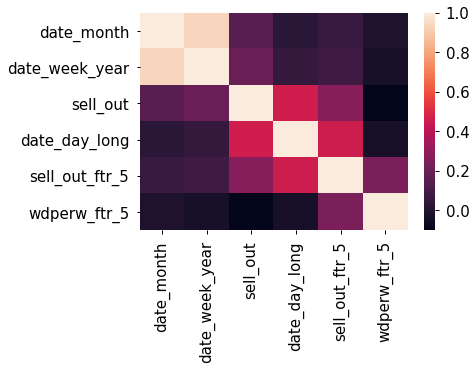

In [38]:
corr_matrix = df[df.columns].corr(method='pearson')
sns.heatmap(corr_matrix);

In [75]:
#################################Linear regresion - ElasticNet/ SVR
#linear = LinearRegression()
#lasso = Lasso()
#ridge = Ridge()
elasticnet = ElasticNet()
#srv = SVR(kernel='rbf',verbose=True) #C=1e3, gamma=0.1


pca1 = PCA(0.95, random_state = RANDOM_STATE)
scaler1 = StandardScaler()
scaler2 = MinMaxScaler(feature_range=(-1, 1))
srv_pipe = Pipeline([   
                        ('pca1',pca1),                    
                        ('scaler1',scaler1),
                        ('scaler2',scaler2),
                        ('poly', PolynomialFeatures(degree=2)),
                        #('linear', linear) 
                        #('lasso', lasso)
                        #('ridge', ridge)
                        ('elasticnet', elasticnet) 
                        #('srv', srv) 
                        
                        
                        
                        ])

srv_pipe_params = {#'srv__C': np.logspace(-0, 6, 4) 
                    #,'srv__gamma': np.logspace(-4, 1, 4) 
                   #,'srv__loss' : ['epsilon_insensitive','squared_epsilon_insensitive']
                    #'srv__kernel: ['rbf', 'linear','poly'] 
                    
                    #'lasso__alpha' : np.logspace(-4, 2, 8) 
                    #'linear__fit_intercept ' : [True,False] 
                    #'ridge__alpha' : np.logspace(0, 4, 4)
                    'elasticnet__alpha' : np.logspace(-1, 10, 20) 
                    ,'elasticnet__l1_ratio' : np.logspace(-2, 1, 4) 
                    }
#svr_rbf = SVR(kernel='rbf', C=1e3, gamma=0.1)
#svr_lin = SVR(kernel='linear', C=1e3)
#svr_poly = SVR(kernel='poly', C=1e3, degree=2)  

model = GridSearchCV(srv_pipe, cv=5, param_grid=srv_pipe_params, scoring='neg_mean_squared_error',verbose=1,n_jobs=-1)
print(X_train.shape)
model.fit(X_train.reshape(-1, X_train.shape[1]*X_train.shape[2]), y_train[:,])
print("Best: %f using %s" % (model.best_score_, model.best_params_))
means = model.cv_results_['mean_test_score']
stds = model.cv_results_['std_test_score']
params = model.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

(197, 4, 5)
Fitting 5 folds for each of 80 candidates, totalling 400 fits
Best: -1129.183394 using {'elasticnet__l1_ratio': 0.1, 'elasticnet__alpha': 1.438449888287663}
-1181.887141 (323.501329) with: {'elasticnet__l1_ratio': 0.01, 'elasticnet__alpha': 0.1}
-1186.798002 (322.832355) with: {'elasticnet__l1_ratio': 0.1, 'elasticnet__alpha': 0.1}
-1634.009402 (496.635618) with: {'elasticnet__l1_ratio': 1.0, 'elasticnet__alpha': 0.1}
-1148.422066 (340.723311) with: {'elasticnet__l1_ratio': 10.0, 'elasticnet__alpha': 0.1}
-1136.503227 (326.982287) with: {'elasticnet__l1_ratio': 0.01, 'elasticnet__alpha': 0.37926901907322497}
-1136.920326 (326.623783) with: {'elasticnet__l1_ratio': 0.1, 'elasticnet__alpha': 0.37926901907322497}
-1302.837401 (317.258871) with: {'elasticnet__l1_ratio': 1.0, 'elasticnet__alpha': 0.37926901907322497}
-1131.682095 (330.284614) with: {'elasticnet__l1_ratio': 10.0, 'elasticnet__alpha': 0.37926901907322497}
-1129.328014 (328.627291) with: {'elasticnet__l1_ratio': 0.

[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:    2.9s finished


In [67]:
### model.add(Reshape((-1,X_train.shape[1]*X_train.shape[2]), input_shape=(X_train.shape[1], X_train.shape[2])))
from keras.layers.advanced_activations import LeakyReLU, PReLU
from keras import optimizers
#model.add(Reshape((-1,X_train.shape[1]*X_train.shape[2]), input_shape=(X_train.shape[1], X_train.shape[2])))

model = Sequential()

model.add(LSTM(7,input_shape=(X_train.shape[1], X_train.shape[2]),return_sequences=True,kernel_initializer='glorot_uniform')) 
model.add(Activation("relu")) 

model.add(Dense(72,kernel_initializer='glorot_uniform')) 
model.add(Activation("relu"))

model.add(LSTM(10,return_sequences=False,kernel_initializer='glorot_uniform')) 
model.add(Activation("relu"))

model.add(Dense(1024,kernel_initializer='glorot_uniform')) 
model.add(Activation("relu"))
model.add(Dropout(0.5))

model.add(Dense(100,kernel_initializer='glorot_uniform')) 
model.add(Activation("relu"))

model.add(Dense(1))

model.compile(loss="mean_squared_error", optimizer=optimizers.RMSprop(lr=0.001, rho=0.5, epsilon=0.05, decay=0.0))
model.fit(X_train, y_train, batch_size=500, nb_epoch=500, validation_data=(X_test, y_test)) #validation_split=0.3


Train on 197 samples, validate on 84 samples
Epoch 1/500
197/197 [==============================] - 4s 22ms/step - loss: 5777.6533 - val_loss: 15557.1533
Epoch 2/500
197/197 [==============================] - 0s 183us/step - loss: 5773.8135 - val_loss: 15548.4492
Epoch 3/500
197/197 [==============================] - 0s 186us/step - loss: 5769.3843 - val_loss: 15538.4141
Epoch 4/500
197/197 [==============================] - 0s 141us/step - loss: 5764.4653 - val_loss: 15526.7920
Epoch 5/500
197/197 [==============================] - 0s 170us/step - loss: 5758.6201 - val_loss: 15513.0117
Epoch 6/500
197/197 [==============================] - 0s 208us/step - loss: 5751.8921 - val_loss: 15496.7900
Epoch 7/500
197/197 [==============================] - 0s 140us/step - loss: 5744.0293 - val_loss: 15477.7305
Epoch 8/500
197/197 [==============================] - 0s 195us/step - loss: 5734.7178 - val_loss: 15455.2695
Epoch 9/500
197/197 [==============================] - 0s 168us/step - loss:

Epoch 75/500
197/197 [==============================] - 0s 146us/step - loss: 1075.6942 - val_loss: 3009.0229
Epoch 76/500
197/197 [==============================] - 0s 196us/step - loss: 1066.0305 - val_loss: 3165.8354
Epoch 77/500
197/197 [==============================] - 0s 202us/step - loss: 1080.8177 - val_loss: 3118.1514
Epoch 78/500
197/197 [==============================] - 0s 184us/step - loss: 1056.8329 - val_loss: 3093.5903
Epoch 79/500
197/197 [==============================] - 0s 181us/step - loss: 1074.6416 - val_loss: 3218.1316
Epoch 80/500
197/197 [==============================] - 0s 202us/step - loss: 1057.1094 - val_loss: 3036.0442
Epoch 81/500
197/197 [==============================] - 0s 209us/step - loss: 1060.2637 - val_loss: 3228.3081
Epoch 82/500
197/197 [==============================] - 0s 162us/step - loss: 1068.1230 - val_loss: 3082.5144
Epoch 83/500
197/197 [==============================] - 0s 217us/step - loss: 1060.0133 - val_loss: 3208.4404
Epoch 84/5

Epoch 150/500
197/197 [==============================] - 0s 166us/step - loss: 997.0533 - val_loss: 2964.7285
Epoch 151/500
197/197 [==============================] - 0s 162us/step - loss: 990.1180 - val_loss: 2805.1829
Epoch 152/500
197/197 [==============================] - 0s 167us/step - loss: 967.6811 - val_loss: 2928.3137
Epoch 153/500
197/197 [==============================] - 0s 143us/step - loss: 987.9644 - val_loss: 2823.1135
Epoch 154/500
197/197 [==============================] - 0s 194us/step - loss: 994.1282 - val_loss: 3009.3293
Epoch 155/500
197/197 [==============================] - 0s 187us/step - loss: 980.4960 - val_loss: 2816.8728
Epoch 156/500
197/197 [==============================] - 0s 155us/step - loss: 966.4971 - val_loss: 2943.2747
Epoch 157/500
197/197 [==============================] - 0s 181us/step - loss: 975.6552 - val_loss: 2770.6277
Epoch 158/500
197/197 [==============================] - 0s 168us/step - loss: 995.7012 - val_loss: 2973.7891
Epoch 159/

Epoch 225/500
197/197 [==============================] - 0s 149us/step - loss: 957.9217 - val_loss: 2640.5500
Epoch 226/500
197/197 [==============================] - 0s 189us/step - loss: 932.6392 - val_loss: 2769.0073
Epoch 227/500
197/197 [==============================] - 0s 197us/step - loss: 932.0941 - val_loss: 2591.0598
Epoch 228/500
197/197 [==============================] - 0s 166us/step - loss: 921.6324 - val_loss: 2769.5276
Epoch 229/500
197/197 [==============================] - 0s 191us/step - loss: 935.1036 - val_loss: 2577.0034
Epoch 230/500
197/197 [==============================] - 0s 167us/step - loss: 915.1335 - val_loss: 2757.0330
Epoch 231/500
197/197 [==============================] - 0s 167us/step - loss: 922.8602 - val_loss: 2626.0171
Epoch 232/500
197/197 [==============================] - 0s 184us/step - loss: 934.8423 - val_loss: 2751.9626
Epoch 233/500
197/197 [==============================] - 0s 226us/step - loss: 900.3907 - val_loss: 2561.4531
Epoch 234/

Epoch 300/500
197/197 [==============================] - 0s 162us/step - loss: 894.4709 - val_loss: 2760.5273
Epoch 301/500
197/197 [==============================] - 0s 166us/step - loss: 862.3387 - val_loss: 2586.3298
Epoch 302/500
197/197 [==============================] - 0s 170us/step - loss: 859.7998 - val_loss: 2749.0942
Epoch 303/500
197/197 [==============================] - 0s 140us/step - loss: 883.1210 - val_loss: 2559.2852
Epoch 304/500
197/197 [==============================] - 0s 172us/step - loss: 884.1758 - val_loss: 2783.1082
Epoch 305/500
197/197 [==============================] - 0s 181us/step - loss: 894.2878 - val_loss: 2594.0999
Epoch 306/500
197/197 [==============================] - 0s 170us/step - loss: 890.3679 - val_loss: 2758.2727
Epoch 307/500
197/197 [==============================] - 0s 188us/step - loss: 862.3246 - val_loss: 2568.8181
Epoch 308/500
197/197 [==============================] - 0s 204us/step - loss: 882.2802 - val_loss: 2784.1060
Epoch 309/

Epoch 375/500
197/197 [==============================] - 0s 238us/step - loss: 804.7242 - val_loss: 2639.3652
Epoch 376/500
197/197 [==============================] - 0s 193us/step - loss: 824.5341 - val_loss: 2790.7942
Epoch 377/500
197/197 [==============================] - 0s 216us/step - loss: 811.5380 - val_loss: 2652.8879
Epoch 378/500
197/197 [==============================] - 0s 173us/step - loss: 792.9881 - val_loss: 2835.7832
Epoch 379/500
197/197 [==============================] - 0s 220us/step - loss: 820.9296 - val_loss: 2632.1099
Epoch 380/500
197/197 [==============================] - 0s 174us/step - loss: 832.6260 - val_loss: 2848.2395
Epoch 381/500
197/197 [==============================] - 0s 162us/step - loss: 812.6592 - val_loss: 2643.7097
Epoch 382/500
197/197 [==============================] - 0s 184us/step - loss: 810.9123 - val_loss: 2831.5444
Epoch 383/500
197/197 [==============================] - 0s 174us/step - loss: 820.9877 - val_loss: 2646.0183
Epoch 384/

Epoch 450/500
197/197 [==============================] - 0s 146us/step - loss: 766.2727 - val_loss: 2965.9241
Epoch 451/500
197/197 [==============================] - 0s 198us/step - loss: 776.6210 - val_loss: 2776.3726
Epoch 452/500
197/197 [==============================] - 0s 161us/step - loss: 752.5606 - val_loss: 2931.1433
Epoch 453/500
197/197 [==============================] - 0s 190us/step - loss: 749.2836 - val_loss: 2767.9302
Epoch 454/500
197/197 [==============================] - 0s 177us/step - loss: 768.5595 - val_loss: 2951.5884
Epoch 455/500
197/197 [==============================] - 0s 176us/step - loss: 778.2400 - val_loss: 2765.1794
Epoch 456/500
197/197 [==============================] - 0s 177us/step - loss: 761.2852 - val_loss: 2947.8164
Epoch 457/500
197/197 [==============================] - 0s 192us/step - loss: 779.4790 - val_loss: 2777.5803
Epoch 458/500
197/197 [==============================] - 0s 184us/step - loss: 770.3972 - val_loss: 2928.0076
Epoch 459/

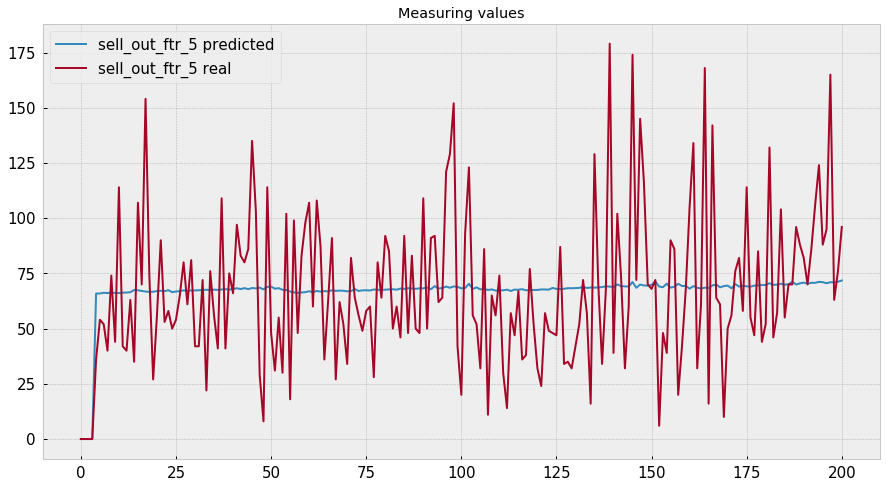

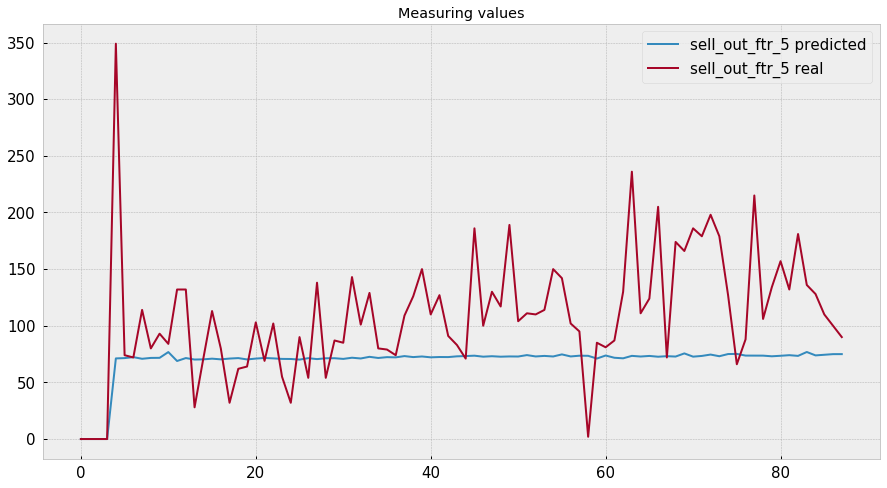

In [76]:
#Для температуры газа
plot_predicted(X_train,y_train,model,range_low = 0,range_high=1)
plot_predicted(X_test,y_test,model,range_low = 0,range_high=1)
#plot_predicted(X_test_1,y_test_1,model,range_low = 0,range_high=1)


In [106]:
data_cut = data_a1[(data_a1['item_id']==9391402)&(data_a1['house_id']==2100)].groupby('date_week_long',as_index = False).max()
data_cut['']

,date_week_long,trans_id,date,sell_big,house_id,item_id,date_dayweek,date_month,date_year,date_month_long,sell_out,sell_in,rest,wdperw
0,104,561.0,2012-12-31,20,2100,9391402,0,12,2012,24,0,20,26,0
1,105,602.0,2013-01-10,2,2100,9391402,3,1,2013,25,2,2,26,3
2,106,601.0,2013-01-15,20,2100,9391402,1,1,2013,25,2,20,42,5
3,108,601.0,2013-02-01,20,2100,9391402,4,2,2013,26,12,20,52,5
4,109,601.0,2013-02-06,-6,2100,9391402,2,2,2013,26,6,0,46,5
5,110,602.0,2013-02-11,6,2100,9391402,0,2,2013,26,6,6,52,5
6,111,601.0,2013-02-20,20,2100,9391402,2,2,2013,26,6,20,56,5
7,112,601.0,2013-02-26,-8,2100,9391402,1,2,2013,26,8,0,44,5
8,114,601.0,2013-03-14,-4,2100,9391402,3,3,2013,27,6,0,40,5
9,115,601.0,2013-03-22,20,2100,9391402,4,3,2013,27,4,20,48,5


AVS HK TIP-ON, Cиловой мех-м  20K2701T
TBX, Напр. с BM, 30 кг, 350 мм, лев. NEW
CLIP top BM, Петля п/фальш вкл 79B9550


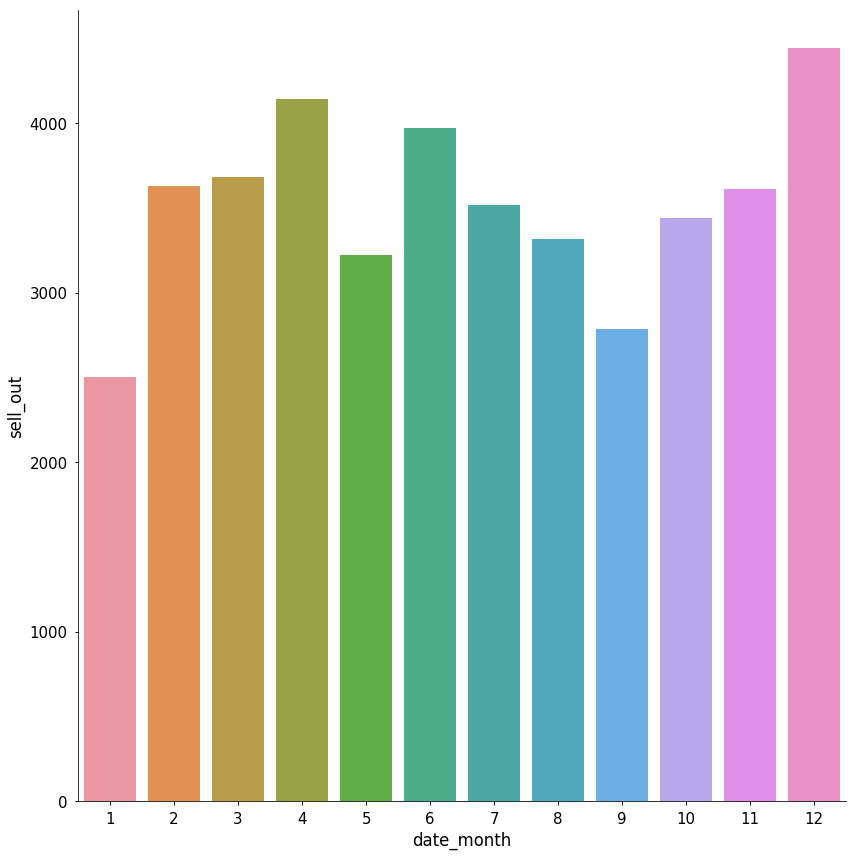

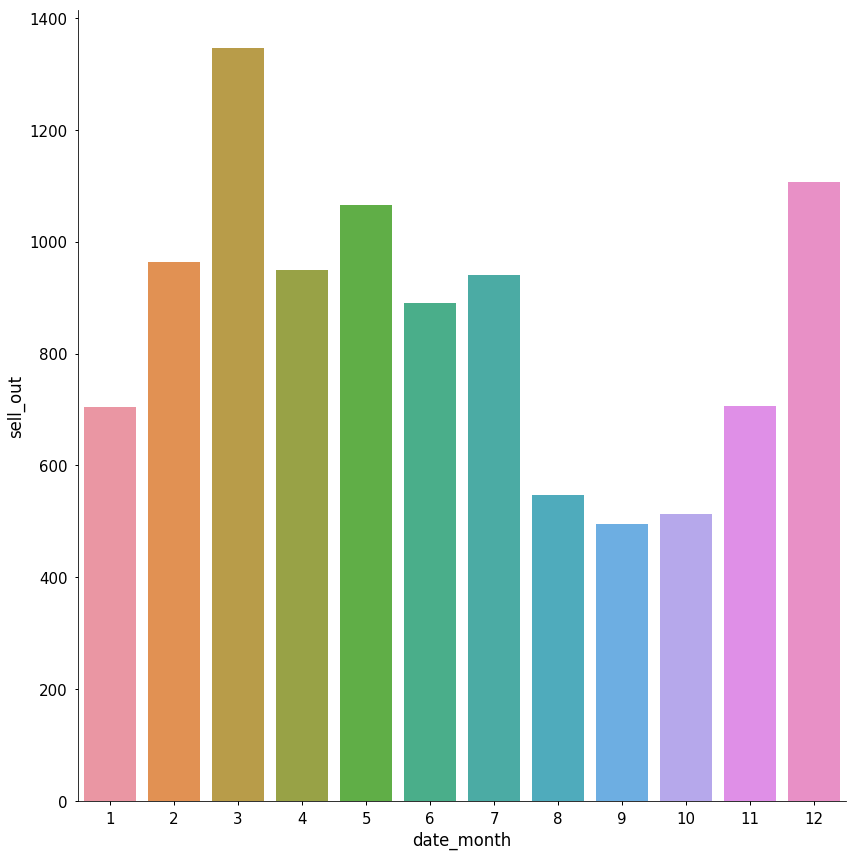

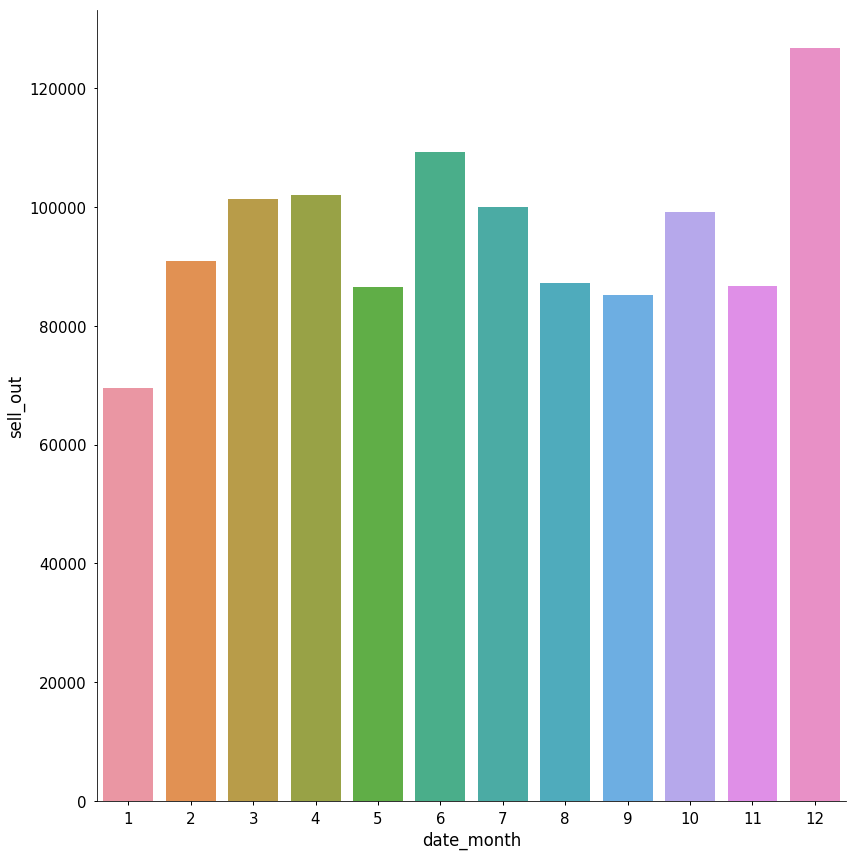

In [10]:
#Продажи по месяцам по продуктам
for k in item_vocab:
    y = data_a1[data_a1['item_id']==k].groupby('date_month',as_index = False)['sell_out'].sum()
    print(item_vocab[k])
    fig = sns.factorplot(x='date_month', y='sell_out', 
               data=y, kind='bar', size=12)
    fig.savefig('date_month.png', bbox_inches='tight')

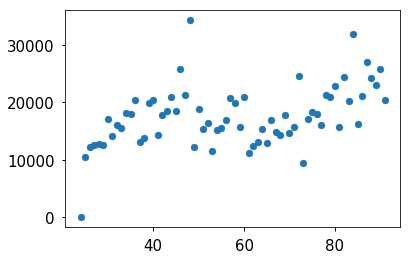

In [11]:
y = data_a1.groupby('date_month_long').sum()
plt.scatter(y.index, y['sell_out'])


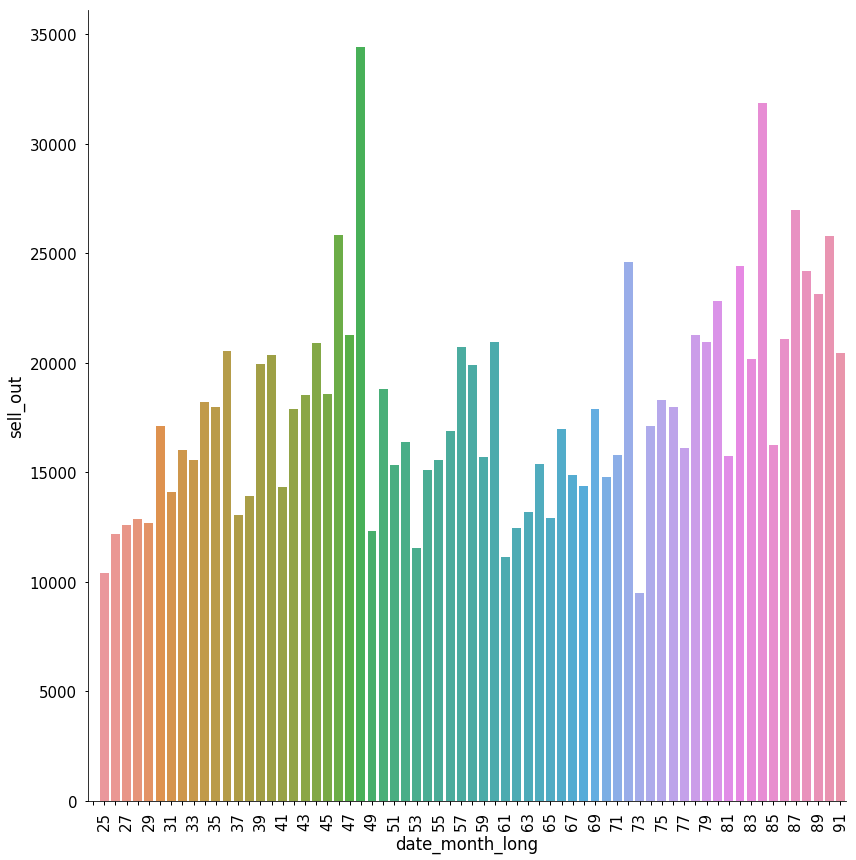

In [12]:
y = data_a1.groupby('date_month_long',as_index = False).sum()
fig = sns.factorplot(x='date_month_long', y='sell_out', 
               data=y, kind='bar', size=12)
#labels = ax.get_xticklabels() # get x labels

for ax in fig.axes.flat:
    labels = ax.get_xticklabels() # get x labels
    for i,l in enumerate(labels):
        if(i%2 == 0): labels[i] = '' # skip even labels
    ax.set_xticklabels(labels, rotation=90) # set new labels
fig.savefig('date_month_long.png', bbox_inches='tight')

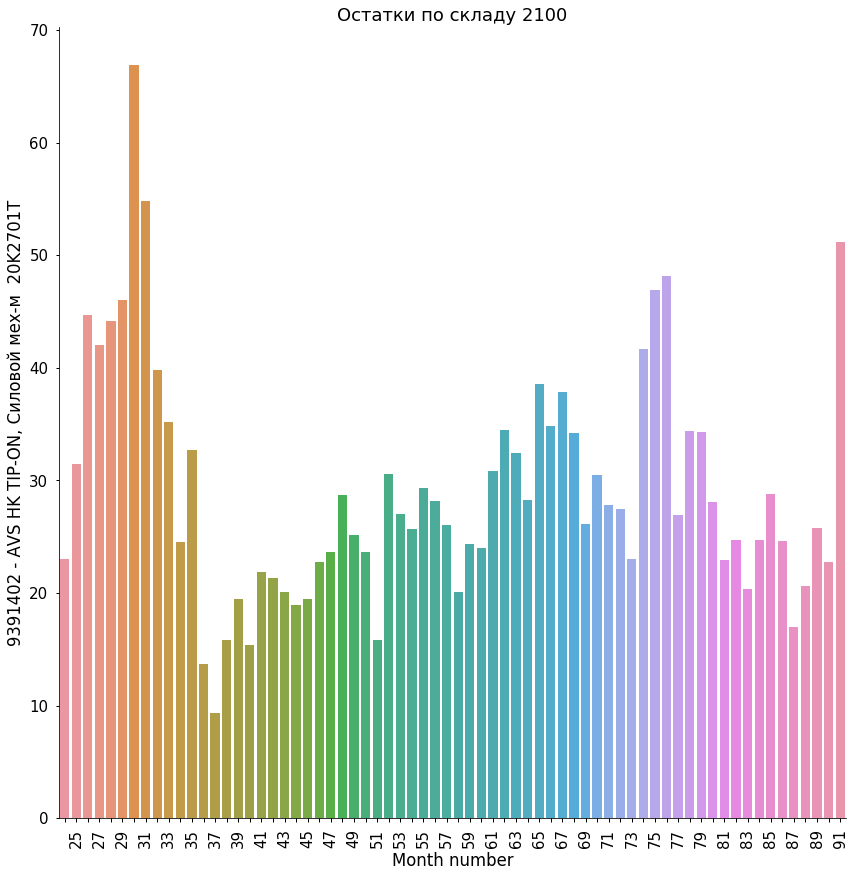

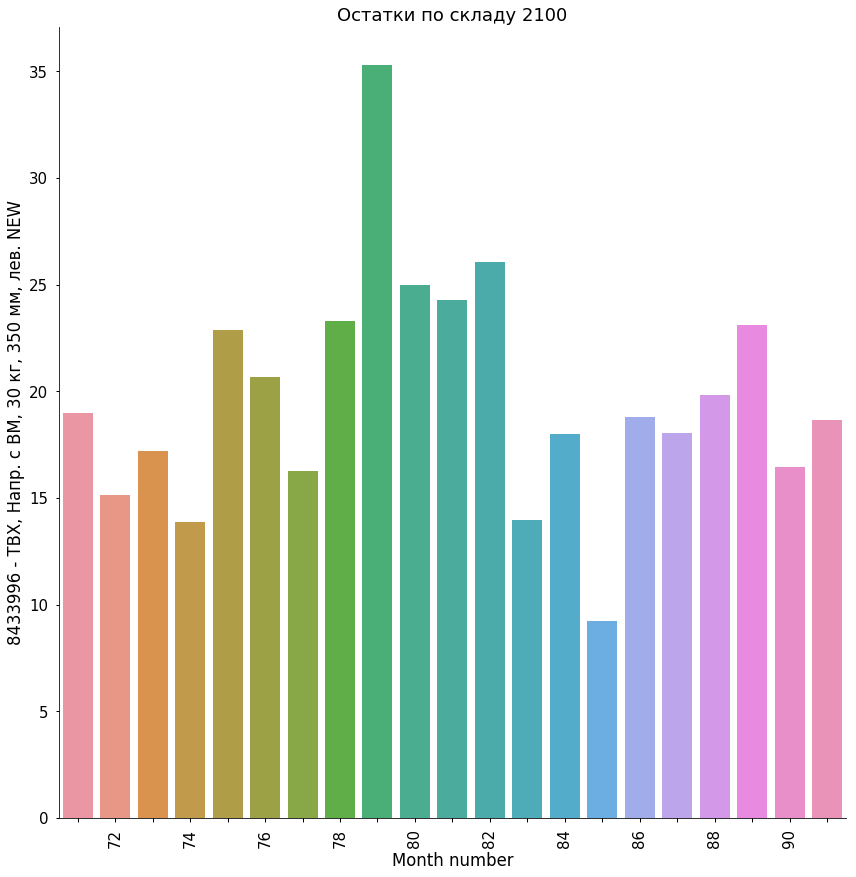

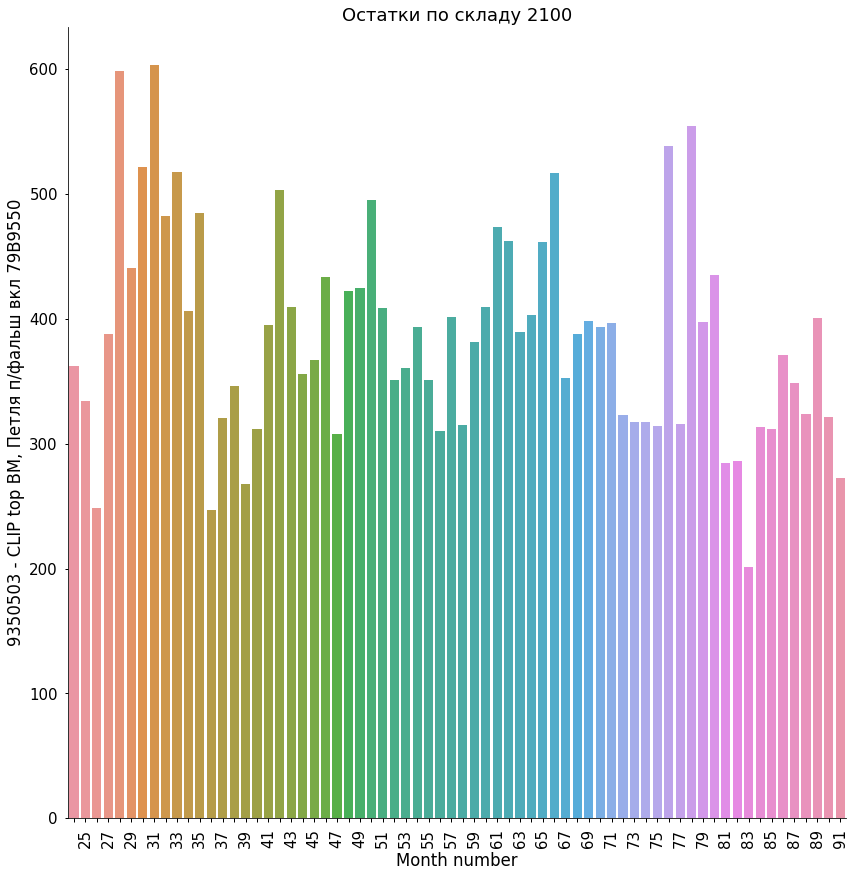

In [13]:
#rest items by house id
sel_h_id = 2100
for k in item_vocab:
    y = data_a1[(data_a1['item_id']==k)&(data_a1['house_id']==sel_h_id)].groupby('date_month_long',as_index = False)['rest'].mean()
    fig = sns.factorplot(x='date_month_long', y='rest', 
               data=y, kind='bar', size=12)
    fig.set_axis_labels("Month number", "%s - %s"%(k,item_vocab[k]))
    for ax in fig.axes.flat:
        labels = ax.get_xticklabels() # get x labels
        ax.set_title("Остатки по складу %s"%sel_h_id)
        for i,l in enumerate(labels):
            if(i%2 == 0): labels[i] = '' # skip even labels
        ax.set_xticklabels(labels, rotation=90) # set new labels
    fig.savefig('rest_by_month_%s_%s.png'%(sel_h_id,k), bbox_inches='tight')

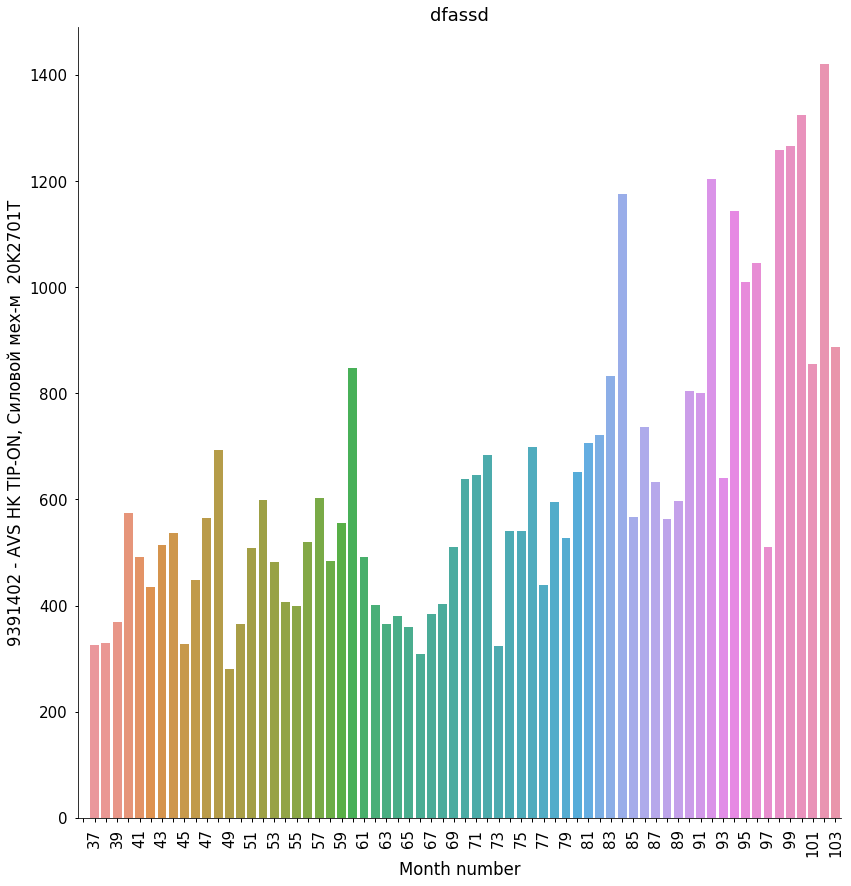

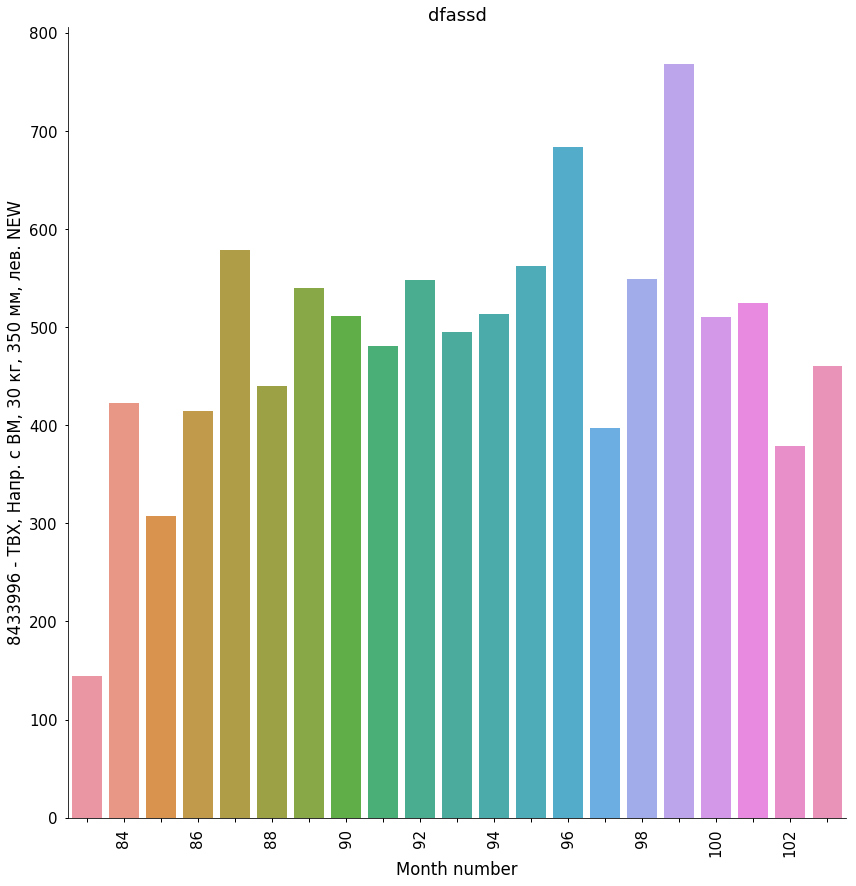

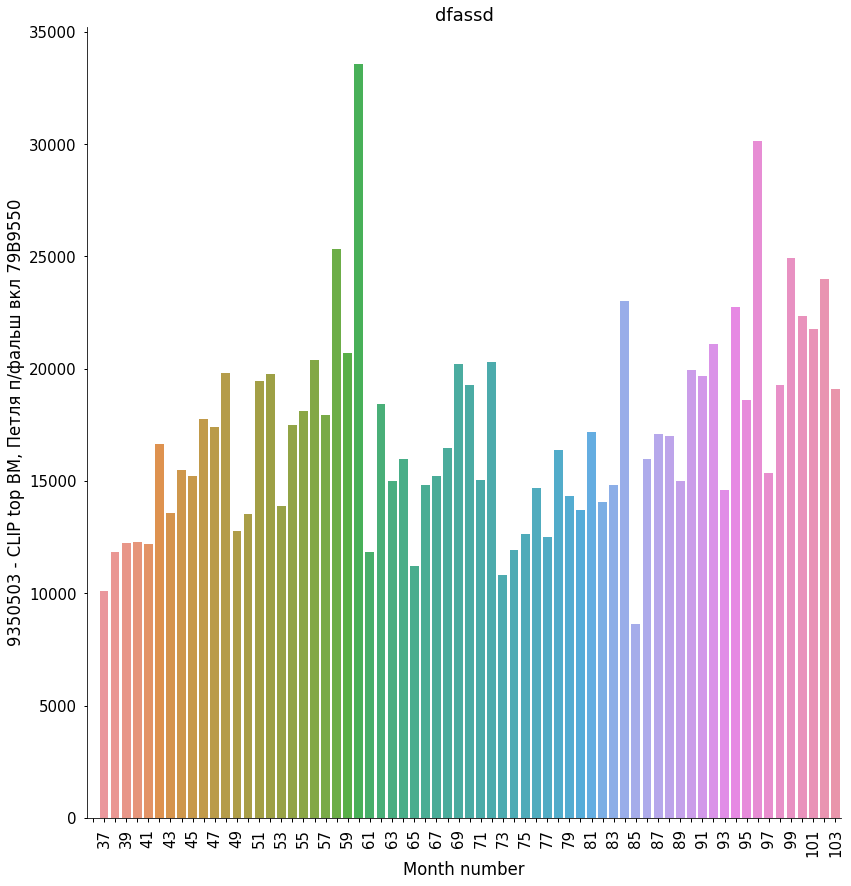

In [204]:
#sell_out by items
for k in item_vocab:
    y = data_a1[data_a1['item_id']==k].groupby('date_month_long',as_index = False)['sell_out'].sum()
    fig = sns.factorplot(x='date_month_long', y='sell_out', 
               data=y, kind='bar', size=12)
    fig.set_axis_labels("Month number", "%s - %s"%(k,item_vocab[k]))
    for ax in fig.axes.flat:
        labels = ax.get_xticklabels() # get x labels
        ax.set_title("Заголовок")
        for i,l in enumerate(labels):
            if(i%2 == 0): labels[i] = '' # skip even labels
        ax.set_xticklabels(labels, rotation=90) # set new labels
    fig.savefig('date_month_long_%s.png'%k, bbox_inches='tight')

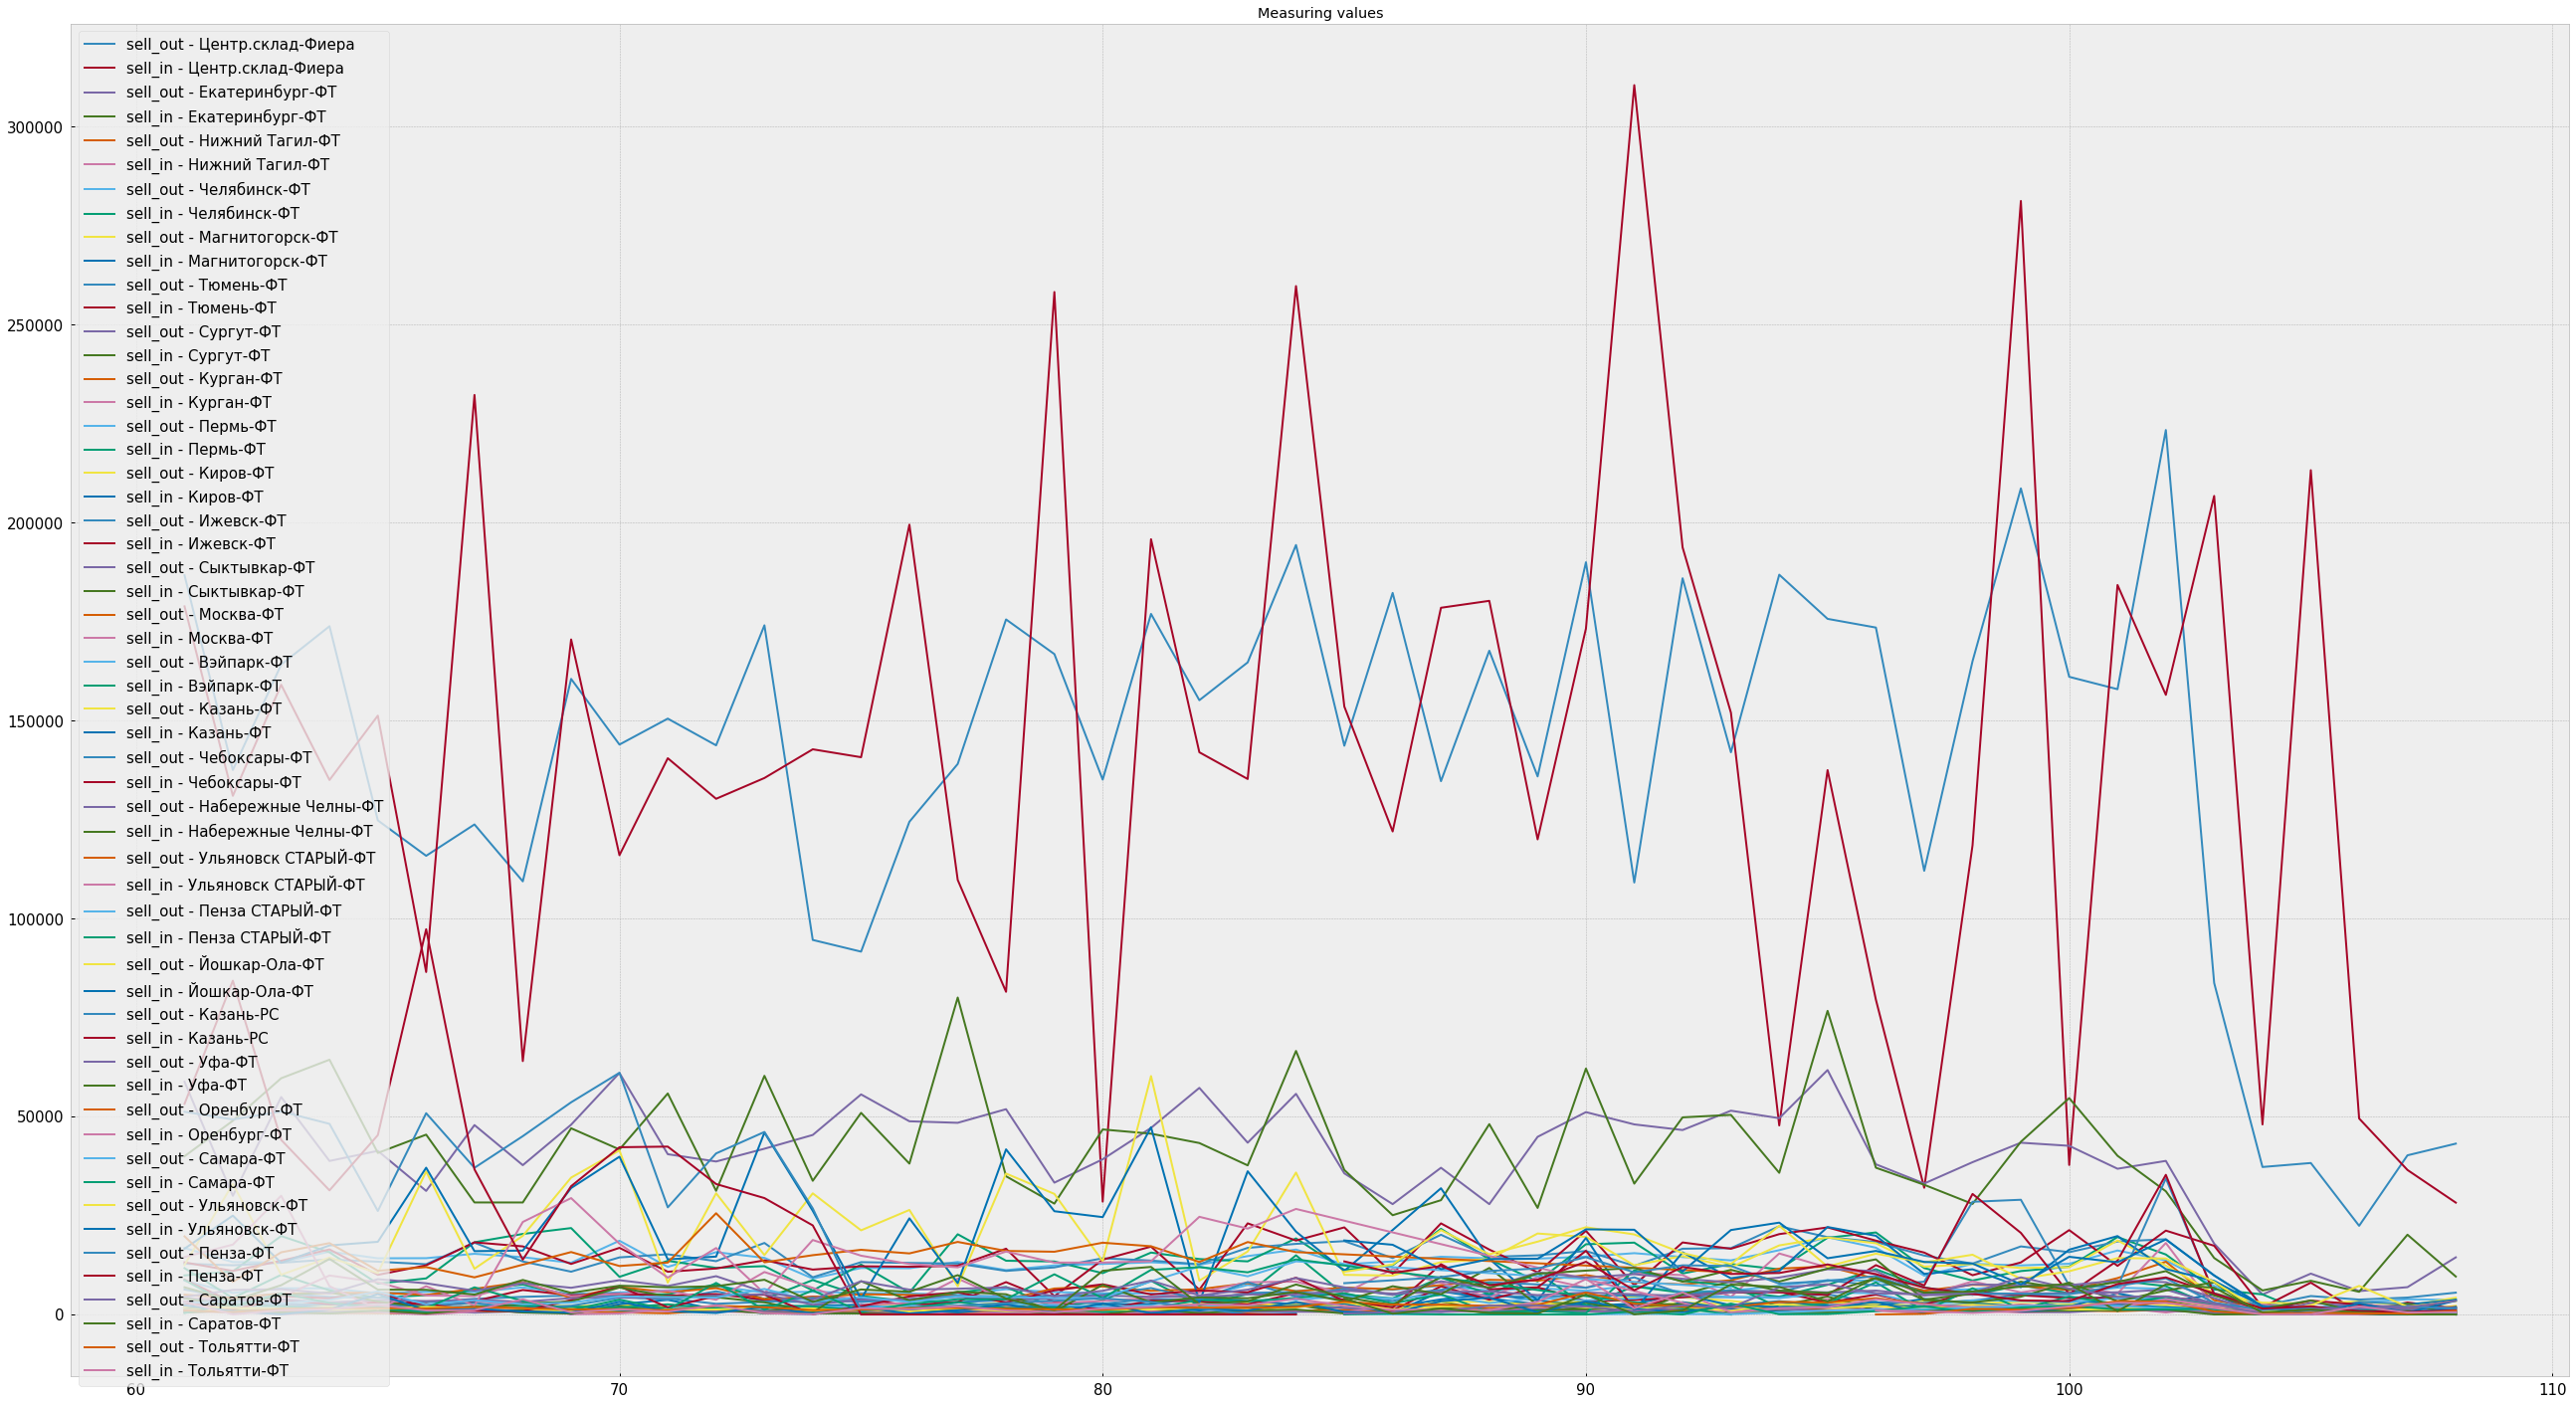

In [13]:
y = data_a1.groupby(['date_month_long','house_id'],as_index = False).sum()
with plt.style.context('bmh'):    
    fig = plt.figure(figsize=(45, 25))
    plt.title('Measuring values')
    for k in y['house_id'].unique():
        plt.plot(y[y['house_id']==k]['date_month_long'],y[y['house_id']==k]['sell_out'],label='sell_out - %s'%house_vocab[k])
        plt.plot(y[y['house_id']==k]['date_month_long'],y[y['house_id']==k]['sell_in'],label='sell_in - %s'%house_vocab[k])
    plt.legend(loc="best")
fig.savefig('date_month_long.house_id.png', bbox_inches='tight')
    

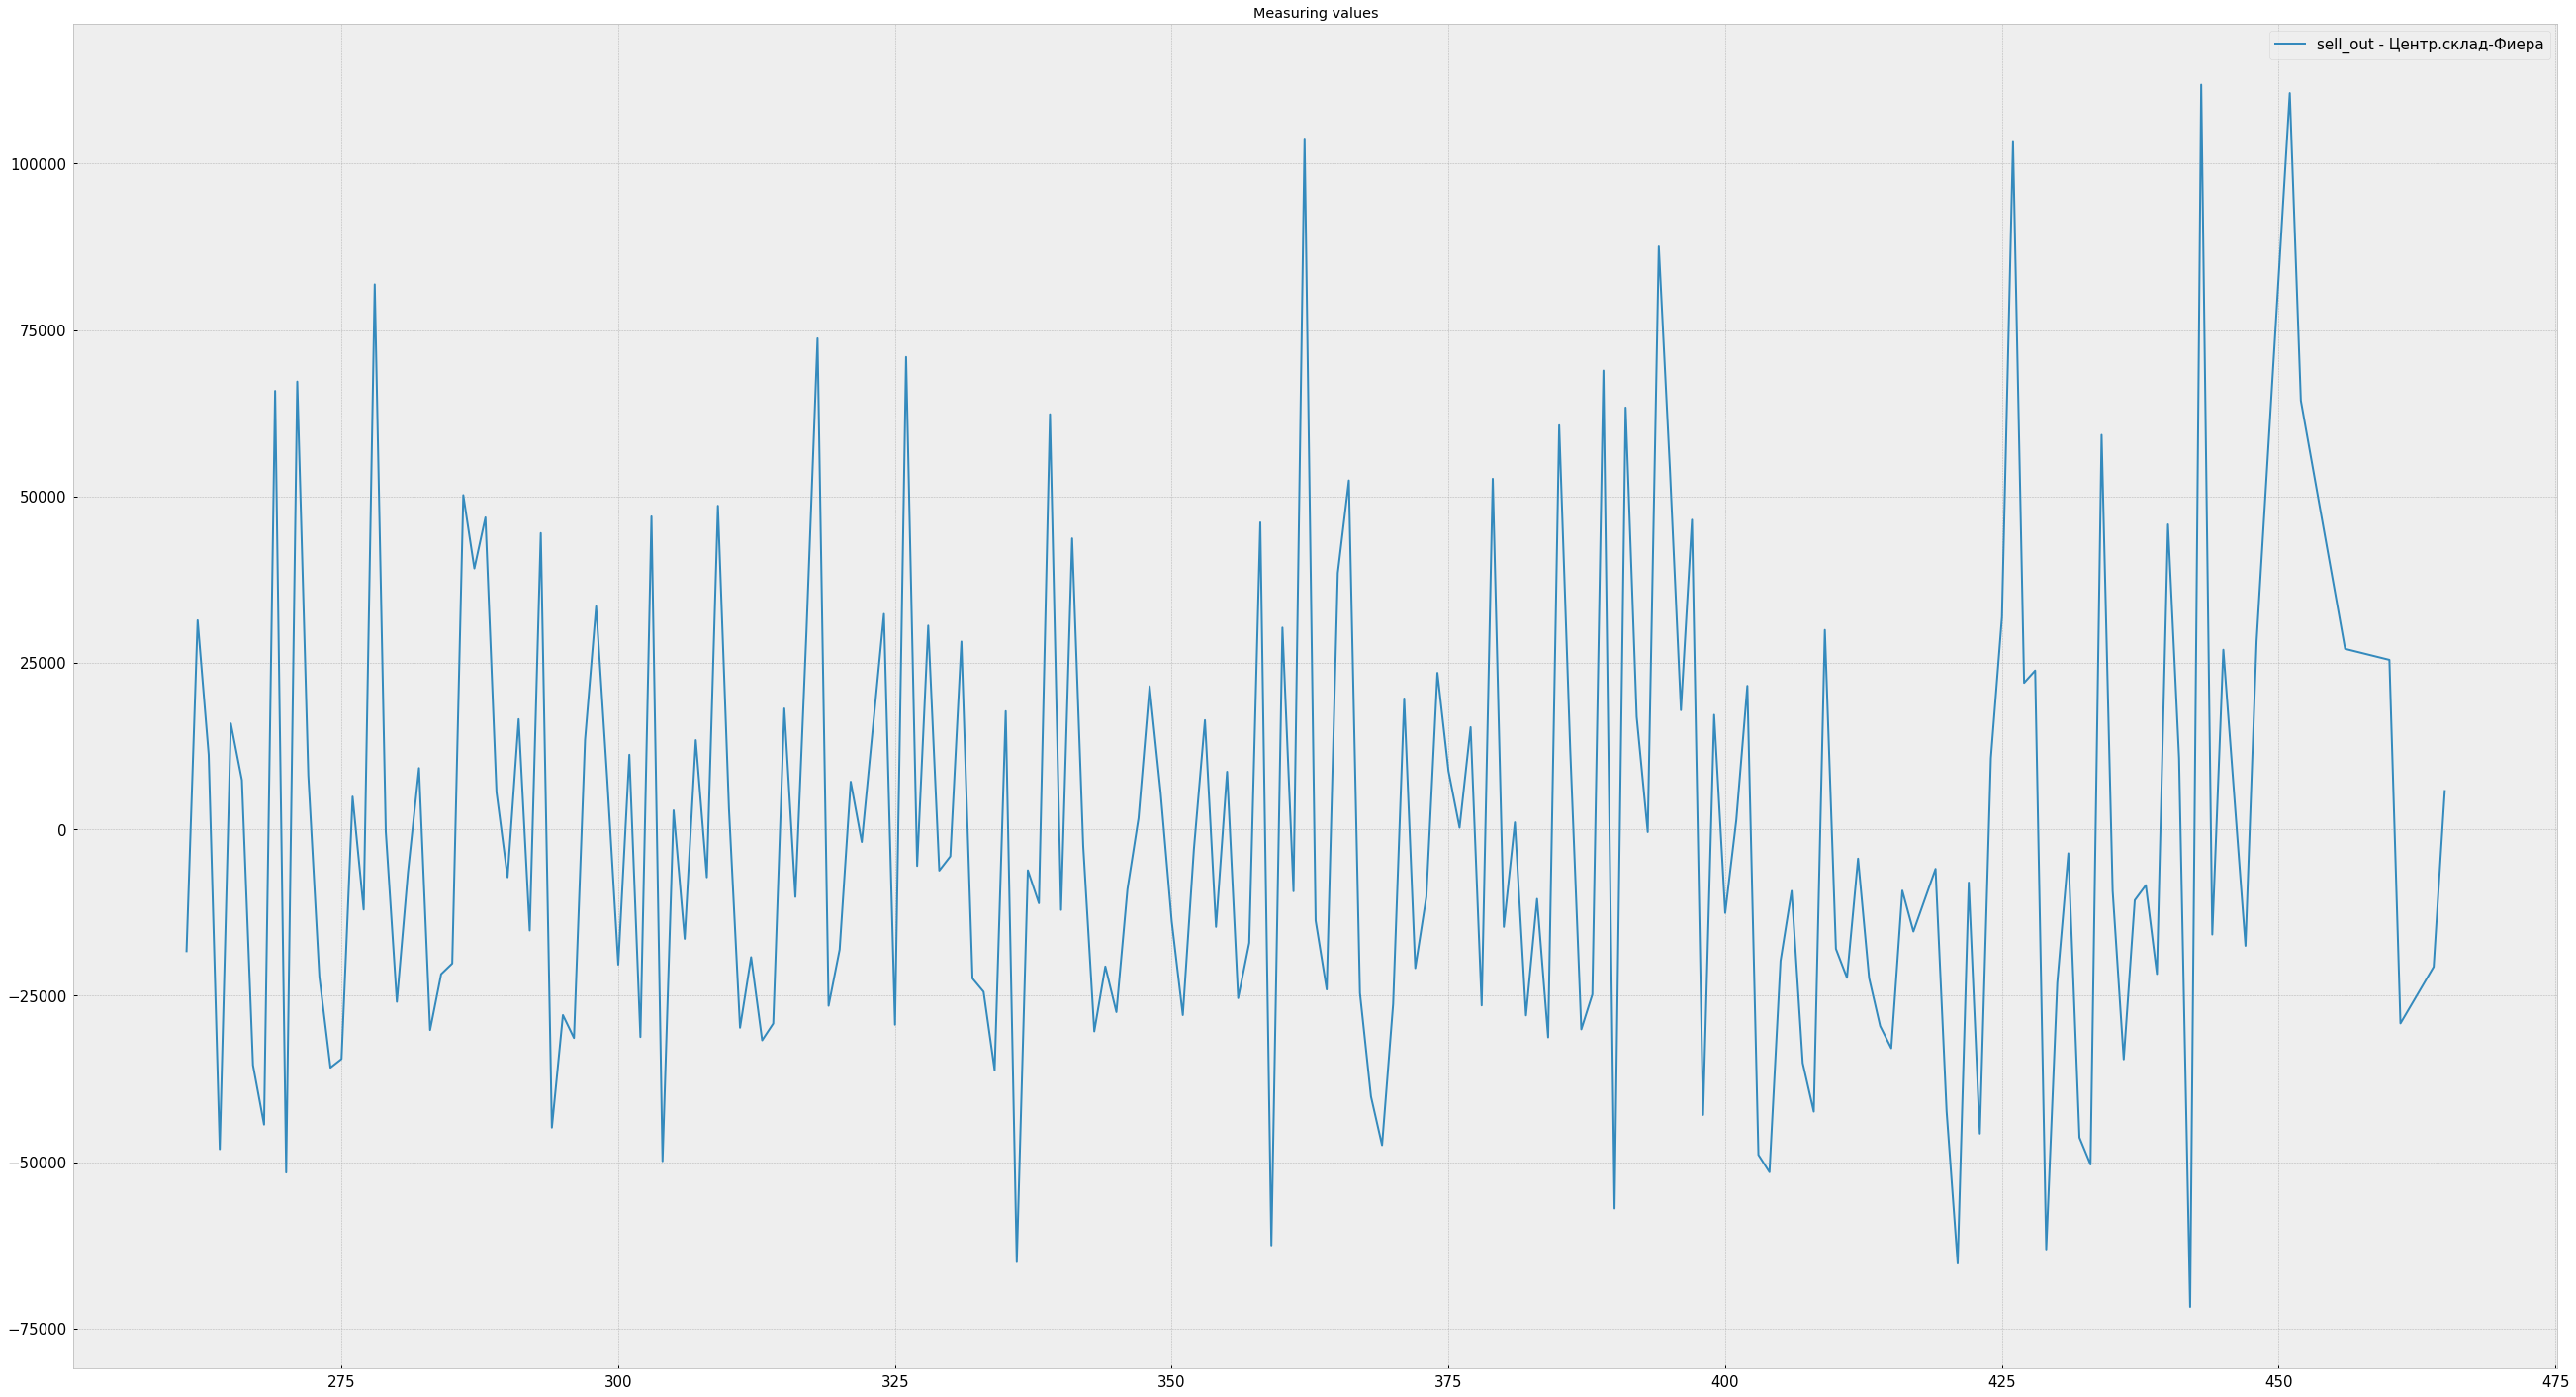

In [23]:
d_temp = data_a1[data_a1['house_id']==1100]
d_temp['sell_out'] = d_temp['sell_in']-d_temp['sell_out']
y = d_temp.groupby(['date_week_long','house_id'],as_index = False).sum()
with plt.style.context('bmh'):    
    fig = plt.figure(figsize=(45, 25))
    plt.title('Measuring values')
    for k in y['house_id'].unique():
        plt.plot(y[y['house_id']==k]['date_week_long'],y[y['house_id']==k]['sell_out'],label='sell_out - %s'%house_vocab[k])
        #plt.plot(y[y['house_id']==k]['date_month_long'],y[y['house_id']==k]['sell_in'],label='sell_in - %s'%house_vocab[k])
    plt.legend(loc="best")
fig.savefig('date_week_long.house_id.png', bbox_inches='tight')

In [14]:
y = data_a1.groupby(['date_month_long','house_id'],as_index = False).sum()
y[y['house_id']==2200].describe()

,date_month_long,house_id,trans_id,sell_big,item_id,date_dayweek,date_month,date_year,sell_out,sell_in
count,48.00,48.0,48.000000,48.000000,4.800000e+01,48.000000,48.000000,4.800000e+01,48.000000,48.000000
mean,84.50,2200.0,616068.833333,-211.729167,5.483908e+09,2417.520833,6706.458333,2.083214e+06,12699.562500,12487.833333
std,14.00,0.0,192936.587473,3955.129913,1.724471e+09,737.234250,4772.556917,6.525626e+05,4001.224759,5532.649726
min,61.00,2200.0,111642.000000,-9116.000000,9.188690e+08,666.000000,878.000000,3.793840e+05,1556.000000,25.000000
25%,72.75,2200.0,594920.000000,-2500.500000,5.309362e+09,2186.000000,2964.750000,2.019277e+06,12299.000000,9411.000000
50%,84.50,2200.0,656356.000000,-218.500000,5.848781e+09,2523.000000,5822.500000,2.217140e+06,13332.000000,12322.000000
75%,96.25,2200.0,719088.750000,2394.500000,6.355202e+09,2919.000000,9840.000000,2.432397e+06,14640.000000,16206.750000
max,108.00,2200.0,897610.000000,8772.000000,8.025116e+09,3595.000000,18072.000000,3.037602e+06,19513.000000,21828.000000


In [245]:
date1 = date(2010, 6, 25)
date2 = date(2010, 7, 2)
date_delta = abs(date1-date2)
date_delta.days//7
type(date1)

datetime.date